## TO DO
1) clean data  

    keep blanks for supplement video type - done
    latest book mark is anything but 'latest viewing' - done
    convert duration column - done
    
2) new columns  

    add, year, month, day of the week columns, hour column
    differentiate series vs movie using semi colon
    add colum for if there is a series which season
    
    

In [4]:
#packages
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.float_format = '{:,.2f}'.format

#some basic functions
def print_shape(dataframe,name):
    #prints dataframe shape and name, name must be in quotes
    # example print(dataframe,'my dataframe')
    print(name+" has: {} rows and {} columns".format(dataframe.shape[0],dataframe.shape[1]))
    

#some less basic functions
def movie_series_parser(x):
    #counts how many semicolons occour, if 1 or zero, assume a movie, if two or more assume a series
    #determines if text is a movie or series by looking to see if the word "Season" or "Part" after a semicolon
    #if it does, a new column will be created called "Season" in the dataframe and that text will be entered there
    #the rest of the function will then delete everthing after the word inclusive of ": Season" or ": Part"
    Movie_or_series = ""
    Season = ""
    Title_of_production = ""
    
    if x.count(":") <2:
        Movie_or_series = 'Movie'
        Title_of_production = x
        return Movie_or_series, Title_of_production, Season
    else:
        Movie_or_series = 'Series'
        try:
            Season_search = re.search(r"(: Season \d)|(: Part \d)",x)
            Season = Season_search.group(1)[2:]
        except:
            Season = 'None'        
        try:    
            Title_search = re.sub(r'(: Season .*)|(: Part .*)','',x)
            Title_of_production = Title_search
        except:
            Title_of_production = x
   
        
        return Movie_or_series, Title_of_production, Season


In [6]:
#import data
viewing_activity_df = pd.read_csv('data/ViewingActivity.csv',parse_dates = ['Start Time'])
billing_history_df = pd.read_csv('data/BillingHistory.csv',parse_dates=['Transaction Date'])

#clean up viewing history data
#latest view is duplicate data and supplemental video are netflix ads
#convert duration to a floating numbers
viewing_activity_df = viewing_activity_df[viewing_activity_df['Latest Bookmark']!='Not latest view']
viewing_activity_df = viewing_activity_df[viewing_activity_df['Supplemental Video Type'].isnull()].reset_index(drop=True)
viewing_activity_df['Duration_floating_hours'] = pd.to_timedelta(viewing_activity_df['Duration'],unit='hours').dt.total_seconds()/3600
#add new columns, year, month, hour, weekday, add if movie or series, if series which season
viewing_activity_df['Year'] = viewing_activity_df['Start Time'].dt.year
viewing_activity_df['Month'] = viewing_activity_df['Start Time'].dt.month
viewing_activity_df['Hour'] = viewing_activity_df['Start Time'].dt.hour
viewing_activity_df['Weekday'] = viewing_activity_df['Start Time'].dt.dayofweek
weekday_dict = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
viewing_activity_df["Weekday"].replace(weekday_dict, inplace=True)
#apply movie parser function to determine if this is a movie, series and what season if series
viewing_activity_df['Movie_or_series'], viewing_activity_df['Title_of_production'], viewing_activity_df['Season'] = zip(*viewing_activity_df['Title'].apply(movie_series_parser))
print_shape(viewing_activity_df,'Viewing Activity')


Viewing Activity has: 5572 rows and 18 columns


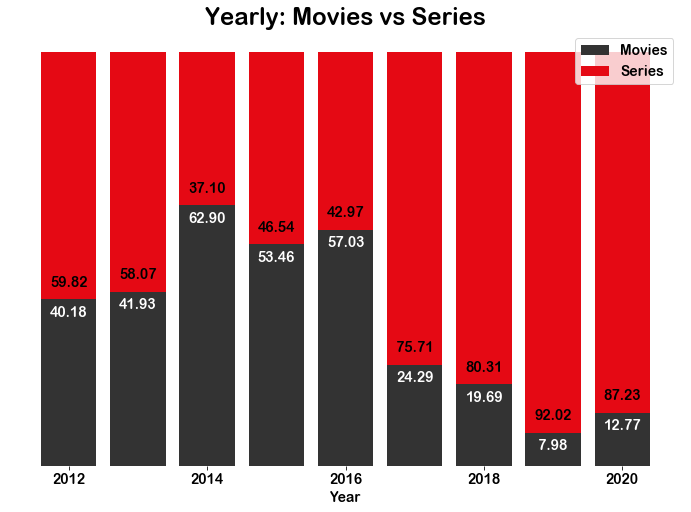

In [7]:
#some plots ugh way more than some plots now



#need some colors
Netflix_red = '#E50914'
Netflix_black = '#333333'
#make yearly sum of viewing hours by movie or series and convert that to percentage of time
yearly_hours = viewing_activity_df.groupby(['Year','Movie_or_series']).sum().reset_index()
yearly_hours_for_plotting = yearly_hours.pivot(index='Year',columns='Movie_or_series',values='Duration_floating_hours').reset_index()
yearly_hours_for_plotting['Movie_pct'] = yearly_hours_for_plotting['Movie']/ (yearly_hours_for_plotting['Movie']+yearly_hours_for_plotting['Series'])
yearly_hours_for_plotting['Series_pct'] = 1-yearly_hours_for_plotting['Movie_pct']


#plot the data
font = {'family' : 'Arial Rounded MT Bold',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(12,8))
movies = ax.bar(yearly_hours_for_plotting['Year'],yearly_hours_for_plotting['Movie_pct']*100,color = Netflix_black,label='Movies')
series = ax.bar(yearly_hours_for_plotting['Year'],yearly_hours_for_plotting['Series_pct']*100,color=Netflix_red,bottom=yearly_hours_for_plotting['Movie_pct']*100,label='Series')
ax.legend()

#needed two of these auto labels to get numbers to show on stacked plots
def autolabel_1(rects,auto_height=True):
    """Attach a text label above each bar in *rects*, displaying its height."""    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',color='w')
def autolabel_2(rects,auto_height=True):
    """Attach a text label above each bar in *rects*, displaying its height."""    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, 100-height),
                    xytext=(0, 10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',color='black')
autolabel_1(movies)
autolabel_2(series)
plt.xlabel('Year')
ax.set_yticklabels([])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False)
plt.title('Yearly: Movies vs Series',fontsize=24)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig('images/yearly_movies_series.png',dpi=500)
plt.show()

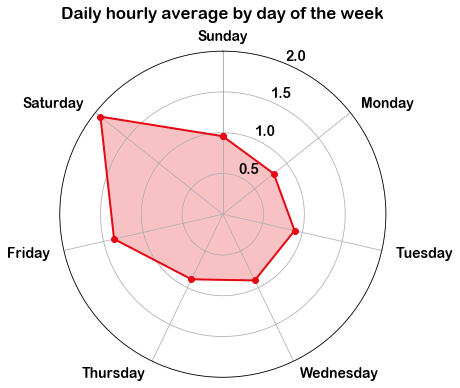

In [8]:
#need to make some other aggregations daily and hourly
daily_hours = viewing_activity_df.resample('D',on='Start Time').sum().reset_index()
daily_hours['Weekday'] = daily_hours['Start Time'].dt.dayofweek
daily_hours["Weekday"].replace(weekday_dict, inplace=True)
average_weekly_hrs = daily_hours.groupby('Weekday').mean().reset_index()
average_weekly_hrs = average_weekly_hrs.reindex([3,1,5,6,4,0,2]).reset_index(drop=True)


hourly_hours = viewing_activity_df.resample('h',on='Start Time').sum().reset_index()


#make a radar chart on average hours per day of the week
labels = average_weekly_hrs['Weekday'].tolist()
values = average_weekly_hrs['Duration_floating_hours'].tolist()
num_vars = len(average_weekly_hrs)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values += values[:1]
angles += angles[:1]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
# Draw the outline of our data.
ax.plot(angles, values, color=Netflix_red, linewidth=2,marker='o')
# Fill it in.
ax.fill(angles, values, color=Netflix_red, alpha=0.25)

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles), labels)
ax.set_rgrids([.5, 1, 1.5, 2])
# Go through labels and adjust alignment based on where
# it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
ax.set_title('Daily hourly average by day of the week', y=1.08)

fig.savefig('images/weekly_average.png',dpi=500)
plt.show()


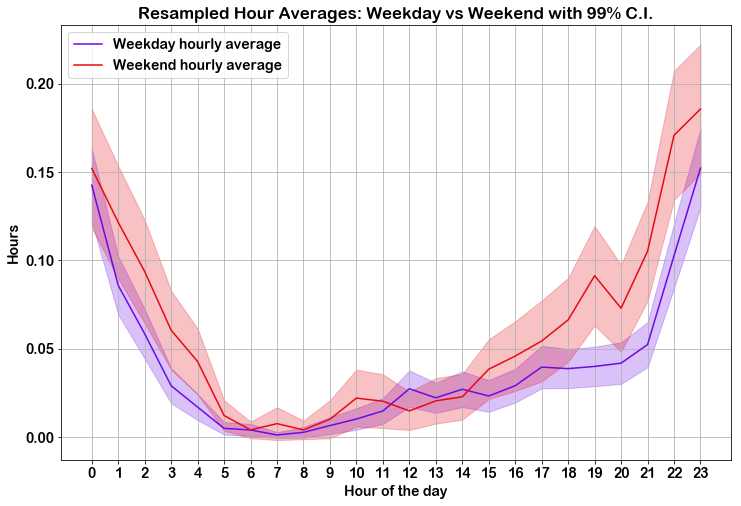

In [33]:
#make a dataframe showing mean and 95% confidence interval
hourly_hours['Weekday'] = hourly_hours['Start Time'].dt.dayofweek
weekday_dict = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
weekday_end_dict = {0:'Weekend',1:'Weekday',2:'Weekday',3:'Weekday',4:'Weekday',5:'Weekday',6:'Weekend'}
hourly_hours['Weekday'].replace(weekday_end_dict, inplace=True)

hourly_hours['Hour'] = hourly_hours['Start Time'].dt.hour

hrs_grouped_df = hourly_hours.groupby(['Weekday','Hour'])['Duration_floating_hours'].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in hrs_grouped_df.index:
    m, c, s = hrs_grouped_df.loc[i]
    ci95_hi.append(m + 2.576*s/math.sqrt(c))
    ci95_lo.append(m - 2.576*s/math.sqrt(c))

hrs_grouped_df['ci99_hi'] = ci95_hi
hrs_grouped_df['ci99_lo'] = ci95_lo
hrs_grouped_df = hrs_grouped_df.reset_index()


weekday_avg_df = hrs_grouped_df[hrs_grouped_df['Weekday']=='Weekday']
weekend_avg_df = hrs_grouped_df[hrs_grouped_df['Weekday']=='Weekend']

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(weekday_avg_df['Hour'],weekday_avg_df['mean'],color='#6C09E5',label='Weekday hourly average')
ax.fill_between(weekday_avg_df['Hour'],weekday_avg_df['ci99_lo'],weekday_avg_df['ci99_hi'],alpha=.25,color='#6C09E5')

ax.plot(weekend_avg_df['Hour'],weekend_avg_df['mean'],color='#E50914',label='Weekend hourly average')
ax.fill_between(weekend_avg_df['Hour'],weekend_avg_df['ci99_lo'],weekend_avg_df['ci99_hi'],alpha=.25,color='#E50914')
plt.grid(True)
plt.xticks(np.arange(min(weekend_avg_df['Hour']), max(weekend_avg_df['Hour'])+1, 1.0))
plt.legend(loc='upper left')
plt.ylabel('Hours')
plt.xlabel('Hour of the day')
plt.title('Resampled Hour Averages: Weekday vs Weekend with 99% C.I.')
fig.savefig('images/daily_average.png',dpi=500)
plt.show()

In [ ]:
#data for regression on viewing activity
hour_dummies_df = pd.get_dummies(hourly_hours, columns=['Hour'],drop_first=True)
keeper_columns = ['Duration_floating_hours','Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23']
dly_avg_hrs_regression = hour_dummies_df[keeper_columns]
hr = [col for col in hour_dummies_df if str(col).startswith('Hour_')]
x = hour_dummies_df[hr]
y = hour_dummies_df['Duration_floating_hours'].tolist()
no_hr = len(dows)
dly_avg_hrs_regression.to_csv('regression.csv')

In [ ]:
#building a daily viewing model using pymc3

import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    #define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sigma=20)
    b = pm.Normal('b', mu=0., sd=1, shape=no_hr-1)
    k = pm.math.matrix_dot(x,b) 
    liklihood = pm.Normal('y',mu=k+intercept,sigma=sigma,observed=y)
    # Inference!
    start = pm.find_MAP()
    
    trace = pm.sample(5000, cores=2,start=start)
    

In [ ]:
b_samples = trace['b']
incercept_samples = trace['Intercept']
modeled = b_samples + incercept_samples.mean()
modeled_plotting =  modeled.T
plt.plot(modeled.mean(axis=0))


In [ ]:
print(alpha_samples.mean())
print(beta_samples.mean())

In [ ]:
plt.scatter(viewing_activity_df['Hour'],viewing_activity_df['Duration_floating_hours'])